In [1]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.ensemble import RandomForestRegressor
import matplotlib
from matplotlib import pylab as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
# Let's load the data
df_0 = pd.read_csv("../data/online_shoppers_intention.csv")

### Missing Values
First we need to check if we have missing value in the dataset.

<font color=blue> Since we have **14** points are missing among **12,330** points (17 categories exclude target variable), we can exclude points with missing value based on MCAR test (**P-value=0.23**), meaning that the missing data is MCAR (i.e., is either Missing At Random or non-ignorable). </font>

In [3]:
# check how many missing values we have 
print(df_0.isnull().sum())
print(df_0.shape)

Administrative             14
Administrative_Duration    14
Informational              14
Informational_Duration     14
ProductRelated             14
ProductRelated_Duration    14
BounceRates                14
ExitRates                  14
PageValues                  0
SpecialDay                  0
Month                       0
OperatingSystems            0
Browser                     0
Region                      0
TrafficType                 0
VisitorType                 0
Weekend                     0
Revenue                     0
dtype: int64
(12330, 18)


In [4]:
# MCAR TEST TO CHECK RANDOMNESS
import math as ma
import scipy.stats as st

def checks_input_mcar_tests(data):
    """ Checks whether the input parameter of class McarTests is correct
            Parameters
            ----------
            data:
                The input of McarTests specified as 'data'
            Returns
            -------
            bool
                True if input is correct
            """

    if not isinstance(data, pd.DataFrame):
        print("Error: Data should be a Pandas DataFrame")
        return False

    if not any(data.dtypes.values == np.float):
        if not any(data.dtypes.values == np.int):
            print("Error: Dataset cannot contain other value types than floats and/or integers")
            return False

    if not data.isnull().values.any():
        print("Error: No NaN's in given data")
        return False

    return True


def mcar_test(data):
    """ Implementation of Little's MCAR test
    Parameters
    ----------
    data: Pandas DataFrame
        An incomplete dataset with samples as index and variables as columns
    Returns
    -------
    p_value: Float
        This value is the outcome of a chi-square statistical test, testing whether the null hypothesis
        'the missingness mechanism of the incomplete dataset is MCAR' can be rejected.
    """

    if not checks_input_mcar_tests(data):
        raise Exception("Input not correct")

    dataset = data.copy()
    vars = dataset.dtypes.index.values
    n_var = dataset.shape[1]

    # mean and covariance estimates
    # ideally, this is done with a maximum likelihood estimator
    gmean = dataset.mean()
    gcov = dataset.cov()

    # set up missing data patterns
    r = 1 * dataset.isnull()
    mdp = np.dot(r, list(map(lambda x: ma.pow(2, x), range(n_var))))
    sorted_mdp = sorted(np.unique(mdp))
    n_pat = len(sorted_mdp)
    correct_mdp = list(map(lambda x: sorted_mdp.index(x), mdp))
    dataset['mdp'] = pd.Series(correct_mdp, index=dataset.index)

    # calculate statistic and df
    pj = 0
    d2 = 0
    for i in range(n_pat):
        dataset_temp = dataset.loc[dataset['mdp'] == i, vars]
        select_vars = ~dataset_temp.isnull().any()
        pj += np.sum(select_vars)
        select_vars = vars[select_vars]
        means = dataset_temp[select_vars].mean() - gmean[select_vars]
        select_cov = gcov.loc[select_vars, select_vars]
        mj = len(dataset_temp)
        parta = np.dot(means.T, np.linalg.solve(select_cov, np.identity(select_cov.shape[1])))
        d2 += mj * (np.dot(parta, means))

    df = pj - n_var

    # perform test and save output
    p_value = 1 - st.chi2.cdf(d2, df)

    return p_value
print('p_value for MCAR test is ')
print(mcar_test(df_0[['Administrative', 'Administrative_Duration', 'Informational','Informational_Duration', 'ProductRelated', 
             'ProductRelated_Duration','PageValues', 'SpecialDay']]))

p_value for MCAR test is 
0.2307537090161722


In [5]:
# drop features with missing values   =>   NOT RECOMMEND, usually just drop the points
df = df_0.dropna(axis=0) #axis = 1: drop the columns, axis = 0: drop the rows

In [6]:
df.shape
# df.isnull().sum().sum()
df

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.000000,0.0,0.00,1.0,0.000000,0.200000,0.200000,0.000000,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,0.000000,0.0,0.00,2.0,64.000000,0.000000,0.100000,0.000000,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0.0,-1.000000,0.0,-1.00,1.0,-1.000000,0.200000,0.200000,0.000000,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0.0,0.000000,0.0,0.00,2.0,2.666667,0.050000,0.140000,0.000000,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0.0,0.000000,0.0,0.00,10.0,627.500000,0.020000,0.050000,0.000000,0.0,Feb,3,3,1,4,Returning_Visitor,True,False
5,0.0,0.000000,0.0,0.00,19.0,154.216667,0.015789,0.024561,0.000000,0.0,Feb,2,2,1,3,Returning_Visitor,False,False
6,0.0,-1.000000,0.0,-1.00,1.0,-1.000000,0.200000,0.200000,0.000000,0.4,Feb,2,4,3,3,Returning_Visitor,False,False
7,1.0,-1.000000,0.0,-1.00,1.0,-1.000000,0.200000,0.200000,0.000000,0.0,Feb,1,2,1,5,Returning_Visitor,True,False
8,0.0,0.000000,0.0,0.00,2.0,37.000000,0.000000,0.100000,0.000000,0.8,Feb,2,2,2,3,Returning_Visitor,False,False
9,0.0,0.000000,0.0,0.00,3.0,738.000000,0.000000,0.022222,0.000000,0.4,Feb,2,4,1,2,Returning_Visitor,False,False


### Preprocessing

In [7]:
# drop the target variable
y = df['Revenue']

df.drop(columns=['Revenue'],inplace=False)

# features that does not need to be preprocess: 'BounceRates', 'ExitRates'
df_perct = df[['BounceRates','ExitRates']]


# OneHot Encoder.
df_cat = df[['OperatingSystems','Browser','Region','TrafficType','VisitorType','Weekend']]

hot_enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
all_hot = hot_enc.fit_transform(df[['OperatingSystems','Browser','Region','TrafficType','VisitorType','Weekend']])
df_alloh = pd.DataFrame(all_hot, columns = hot_enc.get_feature_names(['OperatingSystems','Browser','Region','TrafficType',
                                                                      'VisitorType','Weekend']))

# ordinal encoder
ordinal_ftrs = ['Month','SpecialDay']
ordinal_cats = [['Feb', 'Mar', 'May', 'June','Jul','Aug','Sep','Oct','Nov','Dec'],['0.0','0.2','0.4', '0.6','0.8', '1.0']]

oe = OrdinalEncoder(categories = ordinal_cats)
oe_values = oe.fit_transform(df[ordinal_ftrs])
df_ordinal = pd.DataFrame(data=oe_values,columns = ordinal_ftrs)

In [8]:
# Standard Scalar
df_con = df[['Administrative', 'Administrative_Duration', 'Informational','Informational_Duration', 'ProductRelated', 
             'ProductRelated_Duration','PageValues']]
sta_scaler = StandardScaler()

df_num = pd.DataFrame(sta_scaler.fit_transform(df_con[['Administrative', 'Administrative_Duration', 'Informational',
                                                       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
                                                       'PageValues']]), 
                      columns = ['Administrative', 'Administrative_Duration', 'Informational','Informational_Duration', 
                                 'ProductRelated', 'ProductRelated_Duration','PageValues'])


In [9]:
# Preprocess the target variable ('Revenue')                                                              
le = LabelEncoder()
target_le = le.fit_transform(y.values.ravel())
df_rev = pd.DataFrame(target_le,columns = ['Revenue'])

# Concatenate all dataframe into one large dataframe
df_data = pd.concat([df_alloh,df_ordinal,df_num,df_perct, df_rev],axis=1)

In [10]:
df_data = df_data.iloc[:12316]
df_data.to_csv("../data/preprocessed_online_shoppers_intention.csv", index=False)

In [11]:
# Load the Preprocessed Data
df_preprocessed = pd.read_csv("../data/preprocessed_online_shoppers_intention.csv")

### Balance of the Dataset
- it gives a baseline accuracy score
    - the simplest classifier that predicts class 0 to all points is correct 75.9% of the time
    - a classification model has predictive power if it is  more accurate than the baseline
- it can guide what evaluation metric should be used

In [12]:
label = 'Revenue'
print(df_preprocessed[label].value_counts()/df_preprocessed[label].shape)
print(df[label].value_counts()/df[label].shape)

0.0    0.84508
1.0    0.15492
Name: Revenue, dtype: float64
False    0.84508
True     0.15492
Name: Revenue, dtype: float64


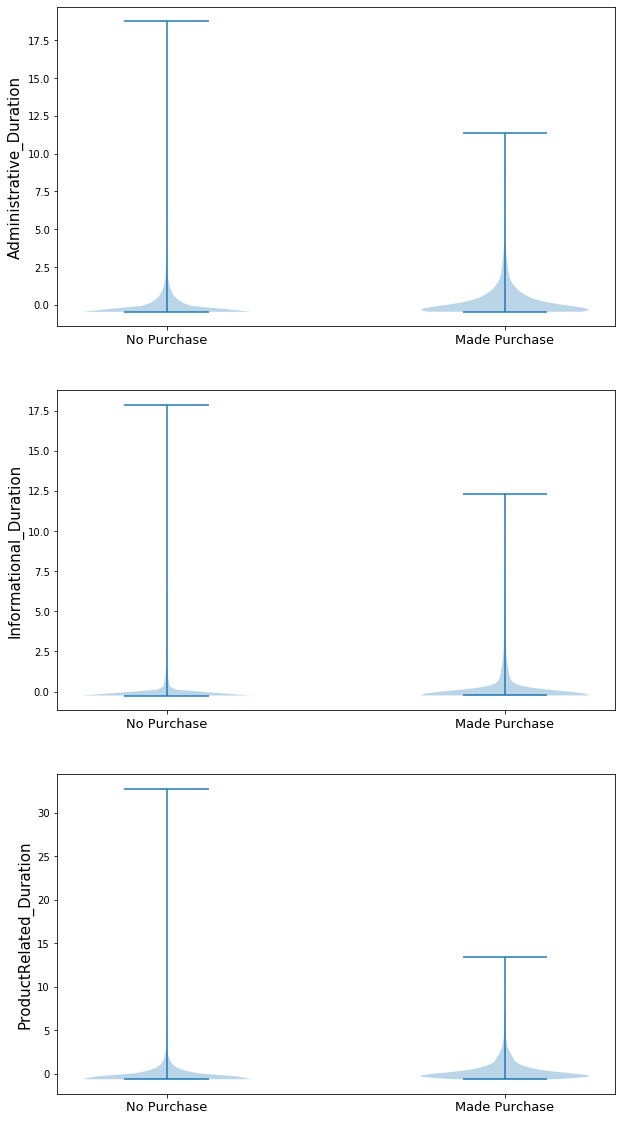

In [13]:
# historgram for administrative duration
plt.rcParams['figure.figsize'] = (10, 20)
plt.subplot(3, 1, 1)
# Administrative Duration VS. Revenue
dataset = [df_preprocessed[df_preprocessed[label]==0]['Administrative_Duration'].values,
           df_preprocessed[df_preprocessed[label]==1]['Administrative_Duration'].values]

plt.violinplot(dataset = dataset)
plt.xticks([1,2],['No Purchase','Made Purchase'],fontsize = 13)
plt.ylabel('label')
plt.ylabel('Administrative_Duration',fontsize=15)

plt.subplot(3, 1, 2)
# Informational Duration VS. Revenue
dataset = [df_preprocessed[df_preprocessed[label]==0]['Informational_Duration'].values,
           df_preprocessed[df_preprocessed[label]==1]['Informational_Duration'].values]

plt.violinplot(dataset = dataset)
plt.xticks([1,2],['No Purchase','Made Purchase'],fontsize = 13)
plt.ylabel('label')
plt.ylabel('Informational_Duration',fontsize=15)

plt.subplot(3, 1, 3)
# Product Related Duration VS. Revenue
dataset = [df_preprocessed[df_preprocessed[label]==0]['ProductRelated_Duration'].values,
           df_preprocessed[df_preprocessed[label]==1]['ProductRelated_Duration'].values]

plt.violinplot(dataset = dataset)
plt.xticks([1,2],['No Purchase','Made Purchase'],fontsize = 13)
plt.ylabel('label')
plt.ylabel('ProductRelated_Duration',fontsize=15)
plt.savefig('../figures/violin_plt_durations.png', bbox_inches = 'tight')
plt.show()

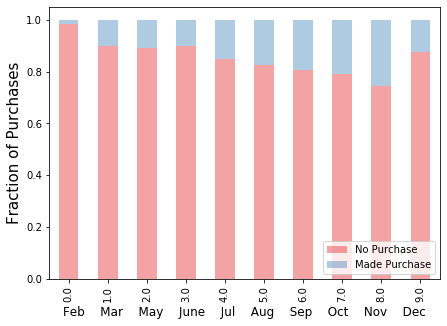

In [14]:
# Month VS. Revenue
# stacked bar plot
plt.rcParams['figure.figsize'] = (7, 5)
count_matrix = df_preprocessed.groupby(['Month', label]).size().unstack()
# print(count_matrix)
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
# print(count_matrix_norm)
count_matrix_norm.columns = ['No Purchase','Made Purchase']

# use a known color palette (see..)
pal = sns.color_palette("Set1")
count_matrix_norm.plot(kind='bar',  color=pal, alpha=0.4, stacked=True)
plt.ylabel('Fraction of Purchases', fontsize=15)
plt.xlabel("Feb    Mar    May    June    Jul    Aug    Sep    Oct    Nov    Dec", fontsize=12)
plt.legend(loc=4)
plt.savefig('../figures/stacked_bar_plt_Month.png', bbox_inches = 'tight')
plt.show()

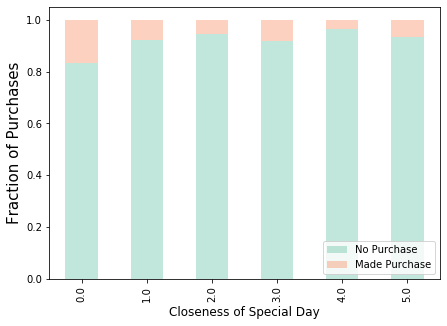

In [28]:
# Special Day vs Revenue
count_matrix1 = df_preprocessed.groupby(['SpecialDay', label]).size().unstack()
count_matrix_norm1 = count_matrix1.div(count_matrix1.sum(axis=1),axis=0)
count_matrix_norm1.columns = ['No Purchase','Made Purchase']

# use a known color palette (see..)
pal = sns.color_palette("Set2")
count_matrix_norm1.plot(kind='bar',  color=pal, alpha=0.4, stacked=True)
plt.ylabel('Fraction of Purchases', fontsize=15)
plt.xlabel("Closeness of Special Day", fontsize=12)
plt.legend(loc=4)
plt.savefig('../figures/stacked_bar_plt_SpecialDay.png', bbox_inches = 'tight')
plt.show()

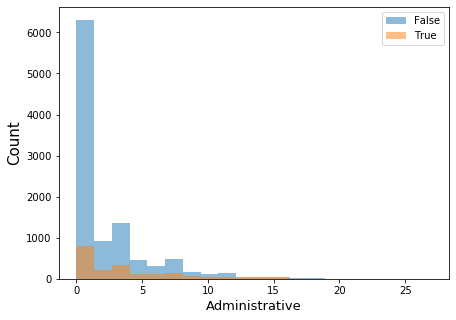

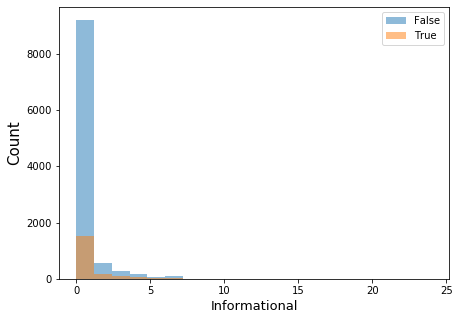

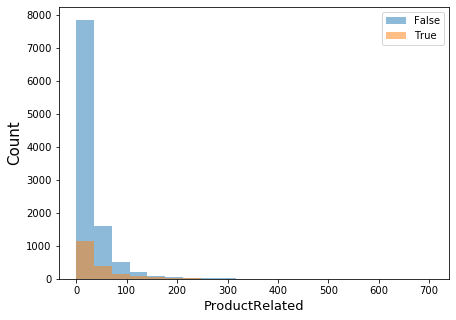

In [15]:
categories = ['Administrative','Informational','ProductRelated']
plt.rcParams['figure.figsize'] = (7, 5)
for i in categories:
    category = df[label].unique()
    bin_range = (df[i].min(),df[i].max())
    for c in category:
        plt.hist(df[df[label]==c][i],alpha=0.5,label=c,range=bin_range,bins=20,density=False)
    plt.legend()
    plt.ylabel('Count',fontsize=15)
    plt.xlabel(i, fontsize=13)
    plt.savefig('../figures/histogram_durations_type.png', bbox_inches = 'tight')
    plt.show()

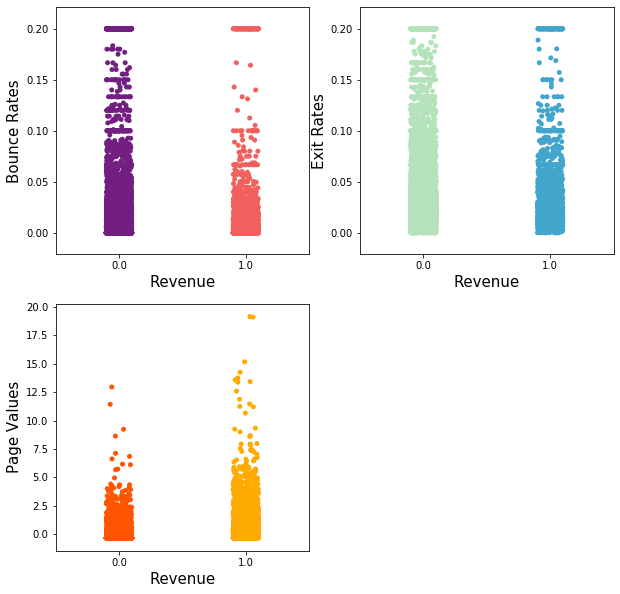

In [45]:
# page values vs revenue

plt.rcParams['figure.figsize'] = (10, 10)

plt.subplot(2, 2, 3)
sns.stripplot(df_preprocessed['Revenue'], df_preprocessed['PageValues'], palette = 'autumn')
plt.xlabel('Revenue', fontsize = 15)
plt.ylabel('Page Values', fontsize = 15)

# # Special days vs revenue
# plt.subplot(2, 2, 2)
# sns.stripplot(df['Month'], df_preprocessed['SpecialDay'], palette = 'magma')
# plt.xlabel('Special Day', fontsize = 15)
# plt.ylabel('Month', fontsize = 15)
# # df[['SpecialDay','Month']].boxplot(by='Month')
# # plt.ylabel('SpecialDay')

# bounce rates vs revenue
plt.subplot(2, 2, 1)
sns.stripplot(df_preprocessed['Revenue'], df_preprocessed['BounceRates'], palette = 'magma')
plt.xlabel('Revenue', fontsize = 15)
plt.ylabel('Bounce Rates', fontsize = 15)

# Exit rate vs revenue
plt.subplot(2, 2, 2)
sns.stripplot(df_preprocessed['Revenue'], df_preprocessed['ExitRates'], palette = 'GnBu')
plt.xlabel('Revenue', fontsize = 15)
plt.ylabel('Exit Rates', fontsize = 15)

plt.savefig('../figures/strip_plt_rates.png', bbox_inches = 'tight')
plt.show()

Revenue   False   True 
Browser                
1        2094.0   365.0
2        6728.0  1223.0
3         100.0     5.0
4         605.0   130.0
5         381.0    86.0
6         154.0    20.0
7          43.0     6.0
8         114.0    21.0
9           1.0     NaN
10        131.0    32.0
11          5.0     1.0
12          7.0     3.0
13         45.0    16.0


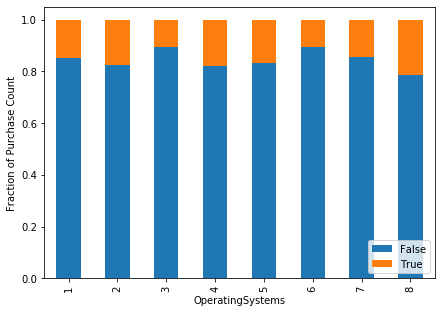

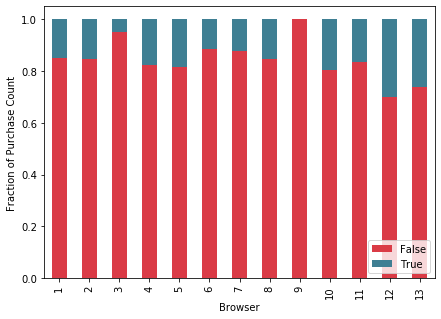

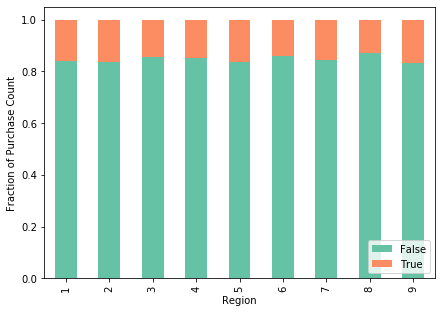

In [18]:
df_cat = df[['OperatingSystems','Browser','Region','TrafficType','VisitorType','Weekend']]
# OperatingSystems
count_matrix1 = df.groupby(['OperatingSystems', label]).size().unstack()
# print(count_matrix1)
count_matrix_norm1 = count_matrix1.div(count_matrix1.sum(axis=1),axis=0)
# print(count_matrix_norm1)
# stacked bar plot
plt.rcParams['figure.figsize'] = (7, 5)

count_matrix_norm1.plot(kind='bar', stacked=True)
plt.ylabel('Fraction of Purchase Count')
plt.legend(loc=4)
# plt.savefig('figures/stacked_bar.png',dpi=300)

# Browser Type
count_matrix2 = df.groupby(['Browser', label]).size().unstack()
print(count_matrix2)
count_matrix_norm2 = count_matrix2.div(count_matrix2.sum(axis=1),axis=0)

pal = sns.diverging_palette(10, 220, sep=80, n=2)
count_matrix_norm2.plot(kind='bar', color=pal, stacked=True)
plt.ylabel('Fraction of Purchase Count')
plt.legend(loc=4)
# plt.savefig('figures/stacked_bar.png',dpi=300)

# Region
pal = sns.color_palette("Set2")
count_matrix3 = df.groupby(['Region', label]).size().unstack()
count_matrix_norm3 = count_matrix3.div(count_matrix3.sum(axis=1),axis=0)

count_matrix_norm3.plot(kind='bar', color=pal, stacked=True)
plt.ylabel('Fraction of Purchase Count')
plt.legend(loc=4)
# plt.savefig('figures/stacked_bar.png',dpi=300)


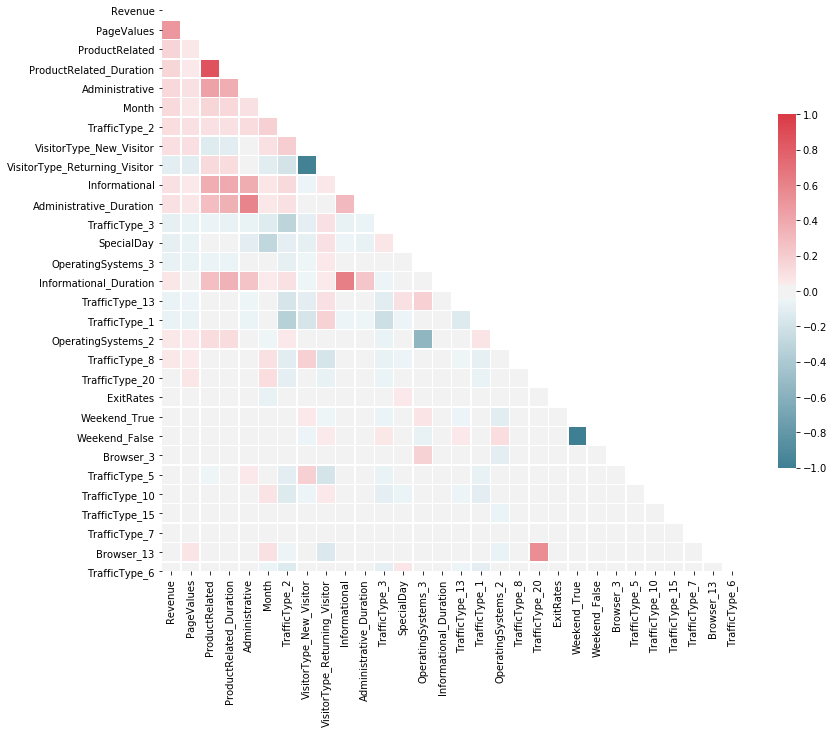

In [19]:
# Correlation Matrix
corrmat = df_preprocessed.corr()

# use the absolute value of the correlation matrix for sorting!
all_cols = np.abs(corrmat).sort_values('Revenue',ascending=False)['Revenue'].index 
cols = all_cols[:30] # positively correlated features

cm = corrmat.loc[cols,cols]

# Generate a mask for the upper triangle
mask = np.zeros_like(cm, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.figure(figsize=(13,13))

heat = sns.heatmap(cm, mask=mask, cmap=cmap, center=0, vmin=-1, vmax=1,
            square=True, linewidths=.5, cbar_kws={'ticks': [-1.0, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0], 'shrink':0.5})

fig = heat.get_figure()
fig.savefig('../figures/abs_corr_coeff_dummies.png', bbox_inches = 'tight')


In [20]:
corrmat = df_preprocessed.corr()['Revenue'].sort_values()
df_cor = corrmat[:30]
print(corrmat)
df_cor.index

VisitorType_Returning_Visitor   -0.103664
TrafficType_3                   -0.082966
SpecialDay                      -0.082468
OperatingSystems_3              -0.070512
TrafficType_13                  -0.067338
                                   ...   
Administrative                   0.138631
ProductRelated_Duration          0.152130
ProductRelated                   0.158280
PageValues                       0.492494
Revenue                          1.000000
Name: Revenue, Length: 67, dtype: float64


Index(['VisitorType_Returning_Visitor', 'TrafficType_3', 'SpecialDay',
       'OperatingSystems_3', 'TrafficType_13', 'TrafficType_1', 'ExitRates',
       'Weekend_False', 'Browser_3', 'TrafficType_15', 'TrafficType_6',
       'BounceRates', 'Region_8', 'Browser_6', 'Region_3', 'TrafficType_18',
       'OperatingSystems_1', 'Region_6', 'TrafficType_19', 'TrafficType_9',
       'Browser_1', 'Region_4', 'Browser_7', 'OperatingSystems_6', 'Browser_2',
       'TrafficType_12', 'Browser_9', 'TrafficType_17', 'OperatingSystems_7',
       'TrafficType_4'],
      dtype='object')

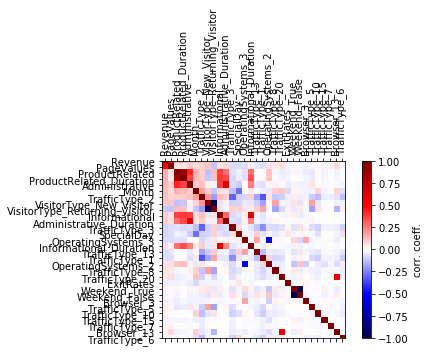

In [21]:
plt.matshow(cm,vmin=-1,vmax=1,cmap='seismic',fignum=0)
plt.colorbar(label='corr. coeff.')
plt.xticks(np.arange(cm.shape[0]),list(cols),rotation=90)
plt.yticks(np.arange(cm.shape[0]),list(cols))
plt.tight_layout()
# plt.savefig('figures/abs_corr_coeff_dummies.png',dpi=300)
plt.show()